#Prediction of COVID-19 cases using various ML models

## RITIKA (18BLC1027)
## SHRENI AGRAWAL (18BLC1012)

In [ ]:

import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import pandas as pd 

from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn import metrics as ms
from sklearn.ensemble import RandomForestRegressor
import datetime

from scipy.integrate import solve_ivp
from scipy.optimize import minimize

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

import plotly.graph_objects as go
import plotly.express as px

color_arr = px.colors.qualitative.Dark24

Import the data (make sure you update this on a daily basis)

In [ ]:
confirmed_link = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
death_link = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
recovered_link = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv"

confirmed_df = pd.read_csv(confirmed_link)
deaths_df = pd.read_csv(death_link)
recoveries_df = pd.read_csv(recovered_link)

In [ ]:
print(confirmed_df.shape)
print(deaths_df.shape )
print(recoveries_df.shape )

(268, 293)
(268, 293)
(255, 293)


In [ ]:
confirmed_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,9/27/20,9/28/20,9/29/20,9/30/20,10/1/20,10/2/20,10/3/20,10/4/20,10/5/20,10/6/20,10/7/20,10/8/20,10/9/20,10/10/20,10/11/20,10/12/20,10/13/20,10/14/20,10/15/20,10/16/20,10/17/20,10/18/20,10/19/20,10/20/20,10/21/20,10/22/20,10/23/20,10/24/20,10/25/20,10/26/20,10/27/20,10/28/20,10/29/20,10/30/20,10/31/20,11/1/20,11/2/20,11/3/20,11/4/20,11/5/20
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,39227,39233,39254,39268,39285,39290,39297,39341,39422,39486,39548,39616,39693,39703,39799,39870,39928,39994,40026,40073,40141,40200,40287,40357,40510,40626,40687,40768,40833,40937,41032,41145,41268,41334,41425,41501,41633,41728,41814,41935
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,13259,13391,13518,13649,13806,13965,14117,14266,14410,14568,14730,14899,15066,15231,15399,15570,15752,15955,16212,16501,16774,17055,17350,17651,17948,18250,18556,18858,19157,19445,19729,20040,20315,20634,20875,21202,21523,21904,22300,22721
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,51067,51213,51368,51530,51690,51847,51995,52136,52270,52399,52520,52658,52804,52940,53072,53325,53399,53584,53777,53998,54203,54402,54616,54829,55081,55357,55630,55880,56143,56419,56706,57026,57332,57651,57942,58272,58574,58979,59527,60169
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1836,1966,1966,2050,2050,2110,2110,2110,2370,2370,2568,2568,2696,2696,2696,2995,2995,3190,3190,3377,3377,3377,3623,3623,3811,3811,4038,4038,4038,4325,4410,4517,4567,4665,4756,4825,4888,4910,5045,5135
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4718,4797,4905,4972,5114,5211,5370,5402,5530,5725,5725,5958,6031,6246,6366,6488,6680,6846,7096,7222,7462,7622,7829,8049,8338,8582,8829,9026,9381,9644,9871,10074,10269,10558,10805,11035,11228,11577,11813,12102


In [ ]:
confirmed_df.keys()

Index(['Province/State', 'Country/Region', 'Lat', 'Long', '1/22/20', '1/23/20',
       '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       ...
       '10/27/20', '10/28/20', '10/29/20', '10/30/20', '10/31/20', '11/1/20',
       '11/2/20', '11/3/20', '11/4/20', '11/5/20'],
      dtype='object', length=293)


Get all the dates for the outbreak

In [ ]:
#FOR WORLD
confirmed = confirmed_df.loc[:, cols[4]:cols[-1]]
deaths = deaths_df.loc[:, cols[4]:cols[-1]]
recoveries = recoveries_df.loc[:, cols[4]:cols[-1]]

In [ ]:
dates = confirmed.keys()
world_cases = []
total_deaths = [] 
mortality_rate = []
recovery_rate = [] 
total_recovered = [] 
total_active = [] 

for i in dates:
    confirmed_sum = confirmed[i].sum()
    death_sum = deaths[i].sum()
    recovered_sum = recoveries[i].sum()
    
    # confirmed, deaths, recovered, and active
    world_cases.append(confirmed_sum)
    total_deaths.append(death_sum)
    total_recovered.append(recovered_sum)
    total_active.append(confirmed_sum-death_sum-recovered_sum)
    
    # calculate rates
    mortality_rate.append(death_sum/confirmed_sum)
    recovery_rate.append(recovered_sum/confirmed_sum)



In [ ]:
#For India
india_confirmed = confirmed_df.loc[confirmed_df['Country/Region'] == 'India']
india_deaths = deaths_df.loc[deaths_df['Country/Region'] == 'India']
india_recoveries = recoveries_df.loc[recoveries_df['Country/Region'] == 'India']
india_active=[]
mortality_rate_india = []
recovery_rate_india = []


confirmed_india = india_confirmed.loc[:, cols[4]:cols[-1]]
deaths_india = india_deaths.loc[:, cols[4]:cols[-1]]
recoveries_india = india_recoveries.loc[:, cols[4]:cols[-1]]

confirmed_india = confirmed_india.values.tolist()
confirmed_india = confirmed_india[0]
deaths_india = deaths_india.values.tolist()
deaths_india = deaths_india[0]
recoveries_india = recoveries_india.values.tolist()
recoveries_india = recoveries_india[0]


l = len(confirmed_india)


for i in range(0,l):
 india_active.append(confirmed_india[i] -deaths_india[i] -recoveries_india[i])
 if (confirmed_india[i] != 0):
    mortality_rate_india.append(deaths_india[i]/confirmed_india[i])
    recovery_rate_india.append(recoveries_india[i]/confirmed_india[i])
 else:
   mortality_rate_india.append(0)
   recovery_rate_india.append(0)

In [ ]:
days_since_1_22 = np.array([i for i in range(len(dates))]).reshape(-1, 1)
world_cases = np.array(world_cases).reshape(-1, 1)
total_deaths = np.array(total_deaths).reshape(-1, 1)
total_recovered = np.array(total_recovered).reshape(-1, 1)

Future forcasting

In [ ]:
days_in_future = 10
future_forcast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forcast[:-10]

Convert integer into datetime for better visualization

In [ ]:
start = '1/22/2020'
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
future_forcast_dates = []
for i in range(len(future_forcast)):
    future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

In [ ]:
# slightly modify the data to fit the model better (regression models cannot pick the pattern)
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days_since_1_22[50:], world_cases[50:], test_size=0.12, shuffle=False) 

#FOR INDIA
india_X_train_confirmed, india_X_test_confirmed, india_y_train_confirmed, india_y_test_confirmed = train_test_split(days_since_1_22[50:], confirmed_india[50:], test_size=0.12, shuffle=False) 

#PREDICTION USING DIFFERENT ML MODELS

#SVM 

In [ ]:
# svm_confirmed = svm_search.best_estimator_
svm_confirmed = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=3, C=0.1)
svm_confirmed.fit(X_train_confirmed, y_train_confirmed)
svm_pred = svm_confirmed.predict(future_forcast)

#FOR INDIA
india_svm_confirmed = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=3, C=0.1)
india_svm_confirmed.fit(india_X_train_confirmed, india_y_train_confirmed)
india_svm_pred = india_svm_confirmed.predict(future_forcast)


In [ ]:
print('MAE:', mean_absolute_error(svm_test_pred, y_test_confirmed))
print('MSE:',mean_squared_error(svm_test_pred, y_test_confirmed))

MAE: 4669932.728746139
MSE: 22111380508342.496


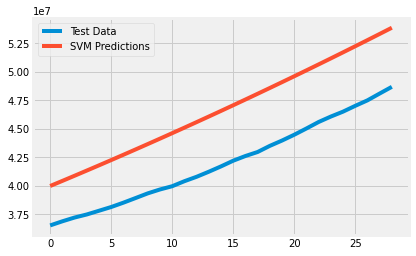

In [ ]:
# check against testing data
svm_test_pred = svm_confirmed.predict(X_test_confirmed)
plt.plot(y_test_confirmed)
plt.plot(svm_test_pred)
plt.legend(['Test Data', 'SVM Predictions'])


#accuracy_score(y2_test,y2_pred)*100
#print('Accuracy ' + str(accuracy_score( svm_test_pred,y_test_confirmed)))


In [ ]:
print('MAE for India:', mean_absolute_error(india_svm_test_pred, india_y_test_confirmed))
print('MSE for India:',mean_squared_error(india_svm_test_pred, india_y_test_confirmed))

MAE for India: 362250.3487639351
MSE for India: 177263118040.54602


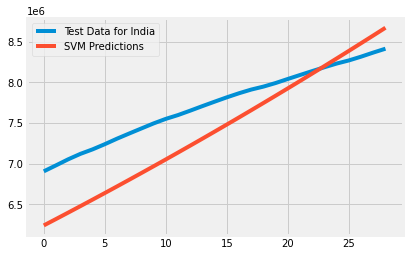

In [ ]:
# FOR INDIA
india_svm_test_pred = india_svm_confirmed.predict(india_X_test_confirmed)
plt.plot(india_y_test_confirmed)
plt.plot(india_svm_test_pred)
plt.legend(['Test Data for India', 'SVM Predictions'])


In [ ]:
# Future predictions using SVM 
svm_df = pd.DataFrame({'Date': future_forcast_dates[-10:], 'SVM Predicted # of Confirmed Cases Worldwide': np.round(svm_pred[-10:])})
svm_df.style.background_gradient(cmap='Greens')

,Date,SVM Predicted # of Confirmed Cases Worldwide
0,11/06/2020,54416122.000000
1,11/07/2020,54969437.000000
2,11/08/2020,55526582.000000
3,11/09/2020,56087568.000000
4,11/10/2020,56652410.000000
5,11/11/2020,57221121.000000
6,11/12/2020,57793714.000000
7,11/13/2020,58370202.000000
8,11/14/2020,58950599.000000
9,11/15/2020,59534917.000000


In [ ]:
# Future predictions using SVM 
india_svm_df = pd.DataFrame({'Date': future_forcast_dates[-10:], 'SVM Predicted # of Confirmed Cases in India': np.round(india_svm_pred[-10:])})
india_svm_df.style.background_gradient(cmap='Greens')

,Date,SVM Predicted # of Confirmed Cases in India
0,11/06/2020,8764988.000000
1,11/07/2020,8861659.000000
2,11/08/2020,8958998.000000
3,11/09/2020,9057009.000000
4,11/10/2020,9155694.000000
5,11/11/2020,9255054.000000
6,11/12/2020,9355093.000000
7,11/13/2020,9455812.000000
8,11/14/2020,9557214.000000
9,11/15/2020,9659301.000000


# POLYNOMIAL REGRESSION

In [ ]:
#transform our data for polynomial regression
poly = PolynomialFeatures(degree=5)
poly_X_train_confirmed = poly.fit_transform(X_train_confirmed)
poly_X_test_confirmed = poly.fit_transform(X_test_confirmed)
poly_future_forcast = poly.fit_transform(future_forcast)

# For India
india_poly = PolynomialFeatures(degree=5)
india_poly_X_train_confirmed = india_poly.fit_transform(india_X_train_confirmed)
india_poly_X_test_confirmed = india_poly.fit_transform(india_X_test_confirmed)
india_poly_future_forcast = india_poly.fit_transform(future_forcast)

In [ ]:
# polynomial regression
linear_model = LinearRegression(normalize=True, fit_intercept=False)
linear_model.fit(poly_X_train_confirmed, y_train_confirmed)
test_linear_pred = linear_model.predict(poly_X_test_confirmed)
linear_pred = linear_model.predict(poly_future_forcast)
print('MAE:', mean_absolute_error(test_linear_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_linear_pred, y_test_confirmed))

MAE: 2715609.667416434
MSE: 10769412725893.605


In [ ]:
# FOR INDIA

india_linear_model = LinearRegression(normalize=True, fit_intercept=False)
india_linear_model.fit(india_poly_X_train_confirmed, india_y_train_confirmed)
india_test_linear_pred = india_linear_model.predict(india_poly_X_test_confirmed)
india_linear_pred = india_linear_model.predict(india_poly_future_forcast)
print('MAE for India:', mean_absolute_error(india_test_linear_pred, india_y_test_confirmed))
print('MSE for India:',mean_squared_error(india_test_linear_pred,india_y_test_confirmed))

MAE for India: 137594.4064965361
MSE for India: 20888797510.686104


In [ ]:
print(linear_model.coef_)
print(india_linear_model.coef_)

[[-8.29077379e+06  2.66297066e+05 -2.87346068e+03  1.57920665e+01
  -2.06403686e-02 -1.16844312e-05]]
[ 2.93946934e+06 -1.39456676e+05  2.47707949e+03 -2.06442109e+01
  8.05165629e-02 -1.11317087e-04]


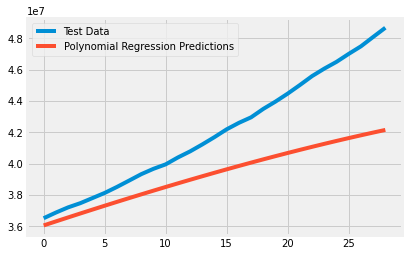

In [ ]:
plt.plot(y_test_confirmed)
plt.plot(test_linear_pred)
plt.legend(['Test Data', 'Polynomial Regression Predictions'])

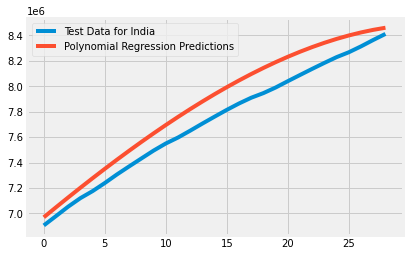

In [ ]:
plt.plot(india_y_test_confirmed)
plt.plot(india_test_linear_pred)
plt.legend(['Test Data for India ', 'Polynomial Regression Predictions'])

In [ ]:
# Future predictions using polynomial regression
linear_pred = linear_pred.reshape(1,-1)[0]
linear_df = pd.DataFrame({'Date': future_forcast_dates[-10:], 'Polynomial Predicted # of Confirmed Cases Worldwide': np.round(linear_pred[-10:])})
linear_df.style.background_gradient(cmap='Greens')

,Date,Polynomial Predicted # of Confirmed Cases Worldwide
0,11/06/2020,42318916.000000
1,11/07/2020,42478525.000000
2,11/08/2020,42633336.000000
3,11/09/2020,42783239.000000
4,11/10/2020,42928127.000000
5,11/11/2020,43067888.000000
6,11/12/2020,43202413.000000
7,11/13/2020,43331588.000000
8,11/14/2020,43455301.000000
9,11/15/2020,43573438.000000


In [ ]:
india_linear_pred = india_linear_pred.reshape(1,-1)[0]
india_linear_df = pd.DataFrame({'Date': future_forcast_dates[-10:], 'Polynomial Predicted # of Confirmed Cases in India': np.round(india_linear_pred[-10:])})
india_linear_df.style.background_gradient(cmap='Greens')

,Date,Polynomial Predicted # of Confirmed Cases in India
0,11/06/2020,8473025.000000
1,11/07/2020,8481974.000000
2,11/08/2020,8486915.000000
3,11/09/2020,8487722.000000
4,11/10/2020,8484267.000000
5,11/11/2020,8476419.000000
6,11/12/2020,8464048.000000
7,11/13/2020,8447018.000000
8,11/14/2020,8425194.000000
9,11/15/2020,8398437.000000


# NEURAL NETWORKS

In [ ]:

 
def train_test(neural_network, X, Y, epochs=5000, training_percent_size = 0.8):
    # This function takes a dataset, splits it into training and testing sets
    # according to training_percent_size, trains a plain LSTM model on it
    # launches preditions on datasets, and plots the result.
    N = len(X)
    # Extract training and testing samples and convert in numpy arrays
    n_training = int(N*training_percent_size)
    X_TRAINING, Y_TRAINING = np.array(X[:n_training]), np.array(Y[:n_training])
    X_TESTING, Y_TESTING = np.array(X[n_training:]), np.array(Y[n_training:])
    # neural_network.fit expect a (samples, input-steps, output-steps) shaped X array
    X_TRAINING = X_TRAINING.reshape((X_TRAINING.shape[0], X_TRAINING.shape[1], 1))
    X_TESTING = X_TESTING.reshape((X_TESTING.shape[0], X_TESTING.shape[1], 1))
    # Training: shuffle=False prevents data shuffling, order is important! 
    for i in range(epochs):
        neural_network.fit(X_TRAINING, Y_TRAINING, epochs = 1, verbose = 0, shuffle = False)
        neural_network.reset_states()
    Y_PREDICTED = []    # we list predictions in this array
    for x in X_TESTING:
        x = x.reshape((1, 1, 1))
        y = neural_network.predict(x, verbose = 0)
        Y_PREDICTED.append(y[0][0])
    #Plot data in read and predictions in blue
    #plt.plot(Y, 'r')
    #plt.plot(range(n_training, N), Y_PREDICTED, 'b')
    #plt.show()
    # Test loss
    #print("Loss =", np.linalg.norm(Y_TESTING - np.array(Y_PREDICTED))**2/len(Y_TESTING))
    # The curve with prediction instead of testing values is returned
    return Y_TRAINING, Y_TESTING ,Y_PREDICTED
 
# Set up the network with one layer of 10 nodes
nn = Sequential()
nn.add(LSTM(10, activation = "relu", input_shape = (1, 1), return_sequences=True))
nn.add(LSTM(10, activation = "relu"))
nn.add(Dense(1))   # the layer has a 1-dimensional output (a number!)
nn.compile(loss="mean_squared_error", optimizer="adam")

#for world
y_training, y_testing, y_predicted = train_test(nn,X_train_confirmed,y_train_confirmed)

#for india
india_y_training, india_y_testing, india_y_predicted = train_test(nn,india_X_train_confirmed, india_y_train_confirmed)

In [ ]:
print('MAE:', mean_absolute_error(y_predicted,y_testing))
print('MSE:',mean_squared_error(y_predicted,y_testing))

MAE: 2652085.0714285714
MSE: 8848760449128.072


In [ ]:
print('MAE:', mean_absolute_error(india_y_predicted,india_y_testing))
print('MSE:',mean_squared_error(india_y_predicted,india_y_testing))

MAE: 670633.6130952381
MSE: 575583278905.8765


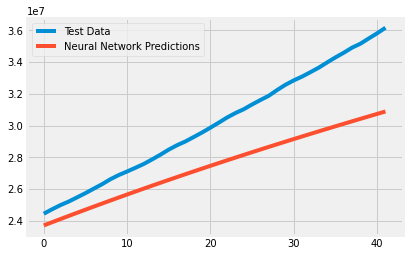

In [ ]:
plt.plot(y_testing)
plt.plot(y_predicted)
plt.legend(['Test Data', 'Neural Network Predictions'])

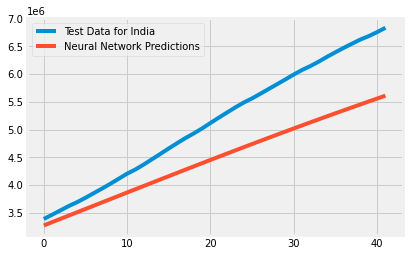

In [ ]:
plt.plot(india_y_testing)
plt.plot(india_y_predicted)
plt.legend(['Test Data for India', 'Neural Network Predictions'])

In [ ]:
y_pred_df = pd.DataFrame({'Date': future_forcast_dates[-10:], 'Neural Network # of Confirmed Cases in Worldwide': np.round(y_predicted[-10:])})
y_pred_df.style.background_gradient(cmap='Greens')

,Date,Neural Network # of Confirmed Cases in Worldwide
0,11/06/2020,29477044.000000
1,11/07/2020,29637456.000000
2,11/08/2020,29796900.000000
3,11/09/2020,29955396.000000
4,11/10/2020,30112964.000000
5,11/11/2020,30269622.000000
6,11/12/2020,30425390.000000
7,11/13/2020,30580288.000000
8,11/14/2020,30734336.000000
9,11/15/2020,30887552.000000


In [ ]:
india_y_pred_df = pd.DataFrame({'Date': future_forcast_dates[-10:], 'Neural Network # of Confirmed Cases in India': np.round(india_y_predicted[-10:])})
india_y_pred_df.style.background_gradient(cmap='Greens')

,Date,Neural Network # of Confirmed Cases in India
0,11/06/2020,5130124.000000
1,11/07/2020,5184826.000000
2,11/08/2020,5239215.000000
3,11/09/2020,5293286.000000
4,11/10/2020,5347034.000000
5,11/11/2020,5400453.000000
6,11/12/2020,5453540.000000
7,11/13/2020,5506291.000000
8,11/14/2020,5558702.000000
9,11/15/2020,5610770.000000


# BAYESIAN RIDGE POLYNOMIAL REGRESSION

In [ ]:
bayesian_poly = PolynomialFeatures(degree=5)
bayesian_poly_X_train_confirmed = bayesian_poly.fit_transform(X_train_confirmed)
bayesian_poly_X_test_confirmed = bayesian_poly.fit_transform(X_test_confirmed)
bayesian_poly_future_forcast = bayesian_poly.fit_transform(future_forcast)

india_bayesian_poly = PolynomialFeatures(degree=5)
india_bayesian_poly_X_train_confirmed = india_bayesian_poly.fit_transform(india_X_train_confirmed)
india_bayesian_poly_X_test_confirmed = india_bayesian_poly.fit_transform(india_X_test_confirmed)
india_bayesian_poly_future_forcast = india_bayesian_poly.fit_transform(future_forcast)


In [ ]:
# bayesian ridge polynomial regression
tol = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
alpha_1 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
alpha_2 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
normalize = [True, False]

bayesian_grid = {'tol': tol, 'alpha_1': alpha_1, 'alpha_2' : alpha_2, 'lambda_1': lambda_1, 'lambda_2' : lambda_2, 
                 'normalize' : normalize}

bayesian = BayesianRidge(fit_intercept=False)
bayesian_search = RandomizedSearchCV(bayesian, bayesian_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)
bayesian_search.fit(bayesian_poly_X_train_confirmed, y_train_confirmed)

#FOR India
bayesian_search.fit(india_bayesian_poly_X_train_confirmed, india_y_train_confirmed)
bayesian_search.best_params_


Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.3s finished


{'alpha_1': 1e-05,
 'alpha_2': 0.0001,
 'lambda_1': 0.001,
 'lambda_2': 1e-07,
 'normalize': True,
 'tol': 0.01}

In [ ]:
bayesian_confirmed = bayesian_search.best_estimator_
test_bayesian_pred = bayesian_confirmed.predict(bayesian_poly_X_test_confirmed)
bayesian_pred = bayesian_confirmed.predict(bayesian_poly_future_forcast)
print('MAE:', mean_absolute_error(test_bayesian_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_bayesian_pred, y_test_confirmed))

MAE: 32903026.216445208
MSE: 1088861524723239.6


In [ ]:
#For India
india_bayesian_confirmed = bayesian_search.best_estimator_
india_test_bayesian_pred = india_bayesian_confirmed.predict(india_bayesian_poly_X_test_confirmed)
india_bayesian_pred = india_bayesian_confirmed.predict(india_bayesian_poly_future_forcast)
print('MAE for India:', mean_absolute_error(india_test_bayesian_pred, india_y_test_confirmed))
print('MSE for India:',mean_squared_error(india_test_bayesian_pred, india_y_test_confirmed))

MAE for India: 1399556.4732099695
MSE for India: 2459270793274.305


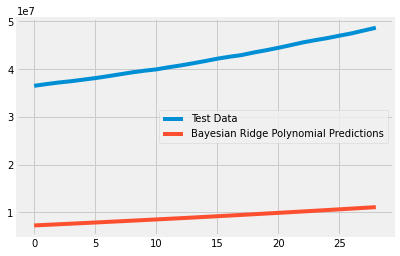

In [ ]:
plt.plot(y_test_confirmed)
plt.plot(test_bayesian_pred)
plt.legend(['Test Data', 'Bayesian Ridge Polynomial Predictions'])

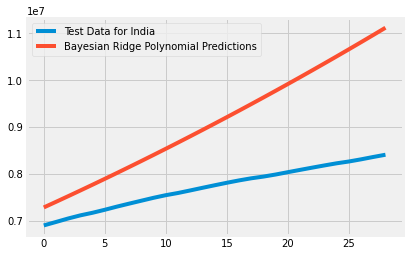

In [ ]:
plt.plot(india_y_test_confirmed)
plt.plot(india_test_bayesian_pred)
plt.legend(['Test Data for India', 'Bayesian Ridge Polynomial Predictions'])

In [ ]:
# Future predictions using polynomial regression
bayesian_pred = bayesian_pred.reshape(1,-1)[0]
bayesian_df = pd.DataFrame({'Date': future_forcast_dates[-10:], 'Polynomial Predicted # of Confirmed Cases Worldwide': np.round(bayesian_pred[-10:])})
bayesian_df.style.background_gradient(cmap='Greens')

,Date,Polynomial Predicted # of Confirmed Cases Worldwide
0,11/06/2020,11272958.000000
1,11/07/2020,11430285.000000
2,11/08/2020,11588978.000000
3,11/09/2020,11749039.000000
4,11/10/2020,11910470.000000
5,11/11/2020,12073276.000000
6,11/12/2020,12237458.000000
7,11/13/2020,12403018.000000
8,11/14/2020,12569959.000000
9,11/15/2020,12738284.000000


In [ ]:
# Future predictions using polynomial regression
india_bayesian_pred = india_bayesian_pred.reshape(1,-1)[0]
india_bayesian_df = pd.DataFrame({'Date': future_forcast_dates[-10:], 'Polynomial Predicted # of Confirmed Cases India': np.round(india_bayesian_pred[-10:])})
india_bayesian_df.style.background_gradient(cmap='Greens')

,Date,Polynomial Predicted # of Confirmed Cases India
0,11/06/2020,11272958.000000
1,11/07/2020,11430285.000000
2,11/08/2020,11588978.000000
3,11/09/2020,11749039.000000
4,11/10/2020,11910470.000000
5,11/11/2020,12073276.000000
6,11/12/2020,12237458.000000
7,11/13/2020,12403018.000000
8,11/14/2020,12569959.000000
9,11/15/2020,12738284.000000


# SIR MODEL

In [ ]:
from datetime import timedelta, datetime
START_DATE = { 'India':'1/30/20'}
class Learner(object):
      def __init__(self, country, loss, start_date = '1/22/20', predict_range = 150, s_0 = 100000, i_0 = 2, r_0 = 10):
        self.country = country
        self.loss = loss
        self.start_date = start_date
        self.predict_range = predict_range
        self.s_0 = s_0
        self.i_0 = i_0
        self.r_0 = r_0
        
      def load_confirmed(self, country):
        df = pd.read_csv(confirmed_link)
        df = df.drop(['Province/State'], axis = 1)
        country_df = df[df['Country/Region'] == country]
        return country_df.iloc[0].loc[self.start_date:]

      def load_recovered(self, country):
        df = pd.read_csv(recovered_link)
        df = df.drop(['Province/State'], axis = 1)
        country_df = df[df['Country/Region'] == country]
        return country_df.iloc[0].loc[self.start_date:]
      
      def load_death(self, country):
        df = pd.read_csv(death_link)
        df = df.drop(['Province/State'], axis = 1)
        country_df = df[df['Country/Region'] == country]
        return country_df.iloc[0].loc[self.start_date:]

      def extend_index(self, index, new_size):
        values = index.values
        current = datetime.strptime(index[-1],'%m/%d/%y')
        while len(values)< new_size:
          current = current + timedelta(days = 1)
          values = np.append(values, datetime.strftime(current, '%m/%d/%y'))
        return values
      def predict(self, beta, gamma, data, recovered, death, country, s_0, i_0, r_0):
        new_index = self.extend_index(data.index, self.predict_range)
        size = len(new_index)
        def SIR(t,y):
          S = y[0]
          I = y[1]
          R = y[2]
          return [-beta*S*I, beta*S*I - gamma*I, gamma*I]
        extended_actual = np.concatenate((data.values, [None]*(size-len(data.values))))
        extended_recovered = np.concatenate((recovered.values, [None]*(size-len(recovered.values))))
        extended_death = np.concatenate((death.values, [None]*(size-len(death.values))))
        return new_index, extended_actual, extended_recovered,  extended_death, solve_ivp(SIR, [0, size], [s_0, i_0, r_0], t_eval = np.arange(0, size, 1))

      def train(self):
        recovered = self.load_recovered(self.country)
        death = self.load_death(self.country)
        data = (self.load_confirmed(self.country) - recovered - death)

        optimal = minimize(loss, [0.001, 0.001], args = (data, recovered, self.s_0, self.i_0, self.r_0), method = 'L-BFGS-B', bounds = [(0.00000001, 0.4),(0.00000001, 0.4) ])
        print(optimal)
        
        beta, gamma = optimal.x
        new_index, extended_actual, extended_recovered,  extended_death, prediction = self.predict(beta, gamma, data, recovered, death, self.country, self.s_0, self.i_0, self.r_0)

        df = pd.DataFrame({'Infected data' : extended_actual, 'Recovered data' : extended_recovered, 'Death data' : extended_death, 'Susceptible' : prediction.y[0], 'Infected' : prediction.y[1],'Recovered' : prediction.y[2]}, index = new_index)

        #save results to csv
        df.to_csv(f"{self.country}.csv")
        fig, ax = plt.subplots(figsize = (10, 10))
        ax.set_title(self.country)
        df.plot(ax= ax)
        print(f"country = {self.country}, beta = {beta: .8f},  gamma = {gamma: .8f}, r_0: {(beta/gamma) : .8f}")
        fig.savefig(f"{self.country}.png")
        return df, fig


In [ ]:
def loss(point, data, recovered, s_0, i_0, r_0):
  size = len(data)
  beta, gamma = point
  def SIR(t, y):
    S = y[0]
    I = y[1]
    R = y[2]
    return [-beta*S*I, beta*S*I - gamma*I, gamma*I]
  solution = solve_ivp(SIR, [0, size], [s_0, i_0, r_0], t_eval = np.arange(0, size, 1), vectorized = True)
  l1 = np.sqrt(np.mean(solution.y[1]-data)**2)
  l2 = np.sqrt(np.mean(solution.y[1]-recovered)**2)
  alpha = 0.1
  return alpha*l1 + (1 - alpha )*l2


      fun: 1329923.7385568006
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([7.21774995e-01, 1.43746698e+07])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 36
      nit: 3
   status: 0
  success: True
        x: array([4.03370015e-04, 1.00000000e-08])
country = India, beta =  0.00040337,  gamma =  0.00000001, r_0:  40337.00153300


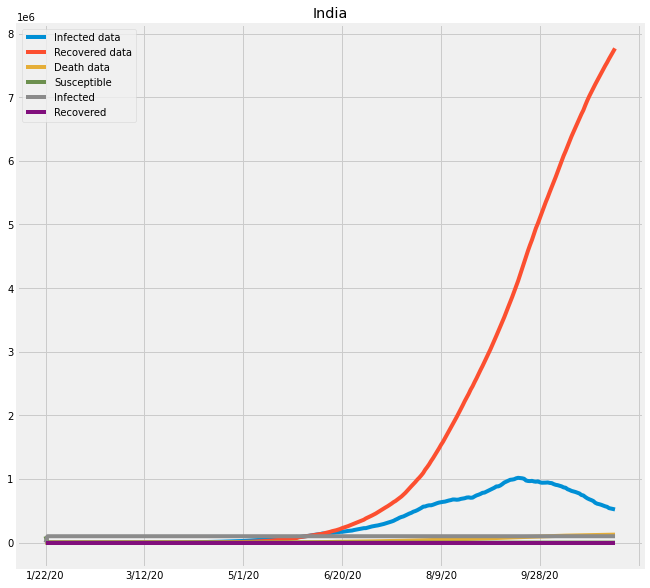

In [ ]:
india_learner = Learner(country = "India", loss = loss, i_0 = 3)
india_sir, india_sir_fig = india_learner.train()

In [ ]:
def plot_sir_prediction(title, df_sir, remove_series = [], yaxis_type = " ", yaxis_title = " "):
  fig = go.Figure()
  title = title
  labels = ['Infected data', 'Recovered data', 'Death data', 'Susceptible', 'Infected', 'Recovered']
  colors = [color_arr[0], color_arr[8], color_arr[2], color_arr[3], color_arr[7], color_arr[16]]
  line_size = [2, 2, 2, 2, 2, 2]

  for index, data_series in enumerate(labels):
    if data_series not in remove_series:
      fig.add_trace(go.Scatter(x=df_sir.index, y= df_sir[data_series], name = labels[index], line = dict(color = colors[index], width = line_size[index]), connectgaps = True))
  xaxis = dict(title = "Date", showline = True, showgrid = True, showticklabels = True, linecolor = 'rgb(204, 204, 204)', linewidth = 2, ticks = 'outside', tickangle = 280, tickfont = dict(family = 'Arial', size = 12, color = 'rgb(82, 82, 82)',),)
  yaxis = dict(title = "Count Count", showline = True, showgrid = True, showticklabels = True, linecolor = 'rgb(204, 204, 204)', linewidth = 2,)
  
  if yaxis_type != " ":
     yaxis['type'] = yaxis_type
  if yaxis_title != " ":
    yaxis['title'] = yaxis_title
  
  # Updating the layout
  fig.update_layout(xaxis = xaxis, yaxis = yaxis, autosize = False, margin = dict(autoexpand = True, l = 10, r = 10, t = 10,), showlegend = True)

  # base annottions for any graph
  annotations = []
  # Title
  annotations.append(dict(xref='paper', yref = 'paper', x= 0.0, y = 1.05, xanchor = 'left', yanchor = 'bottom', text = title, font = dict(family = 'Arial', size = 16, color= 'rgb(37,37,37)'),showarrow = False))
  
  # updating the layout
  fig.update_layout(annotations = annotations)

  return fig

In [ ]:
fig_ = plot_sir_prediction(title = "SIR Model -- Covid-19 Transmission -- Prediction -- India", df_sir = india_sir)
fig_.show()

# RANDOM FOREST

In [ ]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf.fit(X_train_confirmed,y_train_confirmed)
y_pred_confirmed=rf.predict(X_test_confirmed)

In [ ]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf.fit(india_X_train_confirmed,india_y_train_confirmed)
india_y_pred_confirmed=rf.predict(india_X_test_confirmed)

In [ ]:
print('MAE:', mean_absolute_error(y_pred_confirmed, y_test_confirmed))
print('MSE:',mean_squared_error(y_pred_confirmed, y_test_confirmed))

MAE: 6050525.92048276
MSE: 49879028937462.1


In [ ]:
print('MAE:', mean_absolute_error(india_y_pred_confirmed, india_y_test_confirmed))
print('MSE:',mean_squared_error(india_y_pred_confirmed, india_y_test_confirmed))

MAE: 926444.4598275868
MSE: 1052823311580.9717


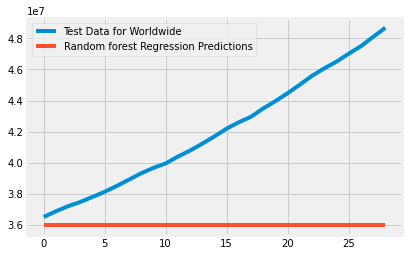

In [ ]:
plt.plot(y_test_confirmed)
plt.plot(y_pred_confirmed)
plt.legend(['Test Data for Worldwide', 'Random forest Regression Predictions'])

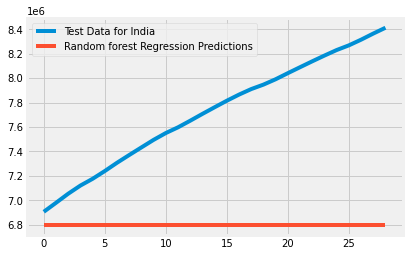

In [ ]:
plt.plot(india_y_test_confirmed)
plt.plot(india_y_pred_confirmed)
plt.legend(['Test Data for India ', 'Random forest Regression Predictions'])

In [ ]:
random_df = pd.DataFrame({'Date': future_forcast_dates[-10:], 'Random Forest Regressor # of Confirmed Cases Worldwide': np.round(y_pred_confirmed[-10:])})
random_df.style.background_gradient(cmap='Greens')

,Date,Random Forest Regressor # of Confirmed Cases Worldwide
0,11/06/2020,35973083.000000
1,11/07/2020,35973083.000000
2,11/08/2020,35973083.000000
3,11/09/2020,35973083.000000
4,11/10/2020,35973083.000000
5,11/11/2020,35973083.000000
6,11/12/2020,35973083.000000
7,11/13/2020,35973083.000000
8,11/14/2020,35973083.000000
9,11/15/2020,35973083.000000


In [ ]:
india_random_df = pd.DataFrame({'Date': future_forcast_dates[-10:], 'Random Forest Regressor # of Confirmed Cases for India': np.round(india_y_pred_confirmed[-10:])})
india_random_df.style.background_gradient(cmap='Greens')

,Date,Random Forest Regressor # of Confirmed Cases for India
0,11/06/2020,6794582.000000
1,11/07/2020,6794582.000000
2,11/08/2020,6794582.000000
3,11/09/2020,6794582.000000
4,11/10/2020,6794582.000000
5,11/11/2020,6794582.000000
6,11/12/2020,6794582.000000
7,11/13/2020,6794582.000000
8,11/14/2020,6794582.000000
9,11/15/2020,6794582.000000
